In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2024-03-18 16:43:51.550314: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:00<00:00, 192.32it/s]


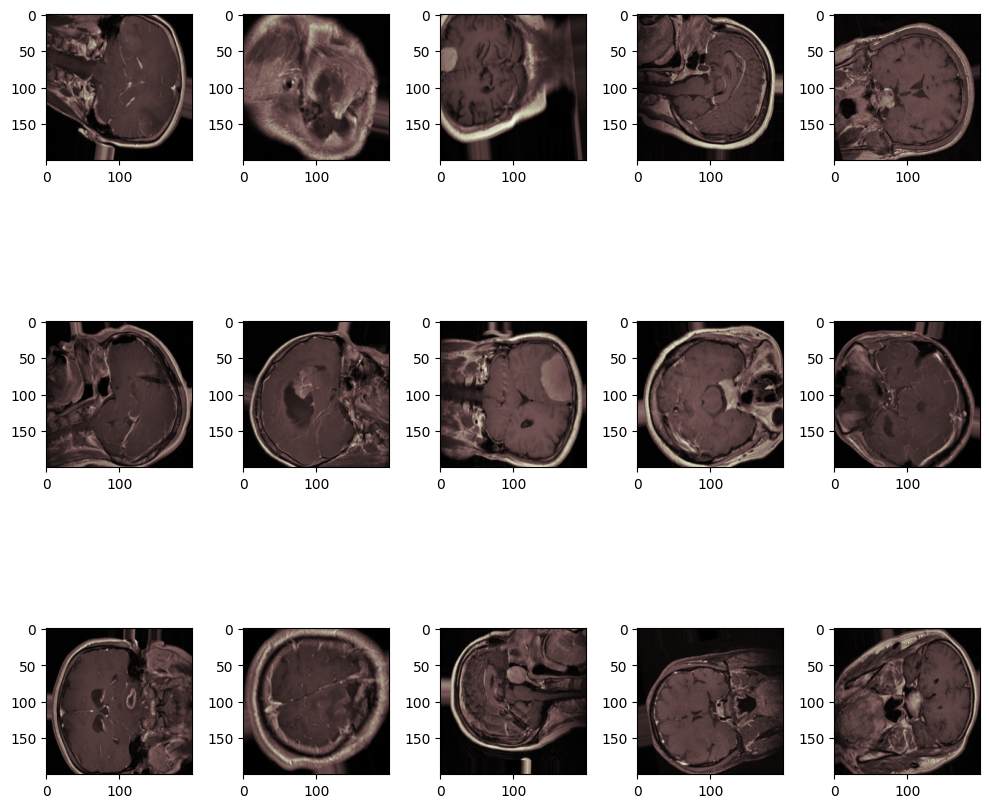

In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

## Without

In [5]:
def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = Conv2D(128, 3, padding='same')(x)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = Conv2D(256, 3, padding='same')(x)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = Conv2D(512, 3, padding='same')(x)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 1.1112 - accuracy: 0.5519
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to model-test.h5
Epoch 1: 9.40 seconds
264/264 [==============================] - 9s 32ms/step - loss: 1.1112 - accuracy: 0.5519 - val_loss: 16.0225 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 1.0118 - accuracy: 0.6541
Epoch 2: val_accuracy improved from 0.33207 to 0.43643, saving model to model-test.h5
Epoch 2: 7.78 seconds
264/264 [==============================] - 8s 29ms/step - loss: 1.0110 - accuracy: 0.6545 - val_loss: 1.7820 - val_accuracy: 0.4364 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.6055 - accuracy: 0.7497
Epoch 3: val_accuracy improved from 0.43643 to 0.61954, saving model to model-test.h5
Epoch 3: 7.75 seconds
264/264 [==============================] - 8s 29ms/step - loss: 0.6057 - accuracy: 0.7496 - 

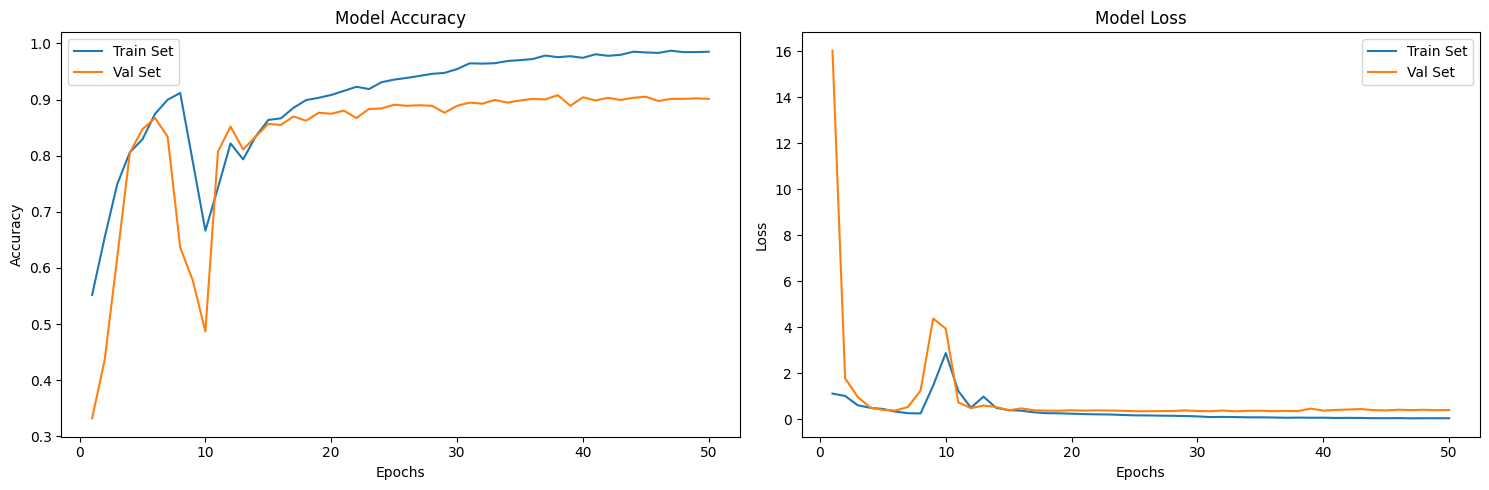

20/20 [==============================] - 0s 9ms/step - loss: 0.4000 - accuracy: 0.9202
Test Accuracy:  92.02
              precision    recall  f1-score   support

      glioma     0.9559    0.9091    0.9319       286
  meningioma     0.8767    0.9014    0.8889       142
   pituitary     0.9031    0.9516    0.9267       186

    accuracy                         0.9202       614
   macro avg     0.9119    0.9207    0.9158       614
weighted avg     0.9216    0.9202    0.9204       614



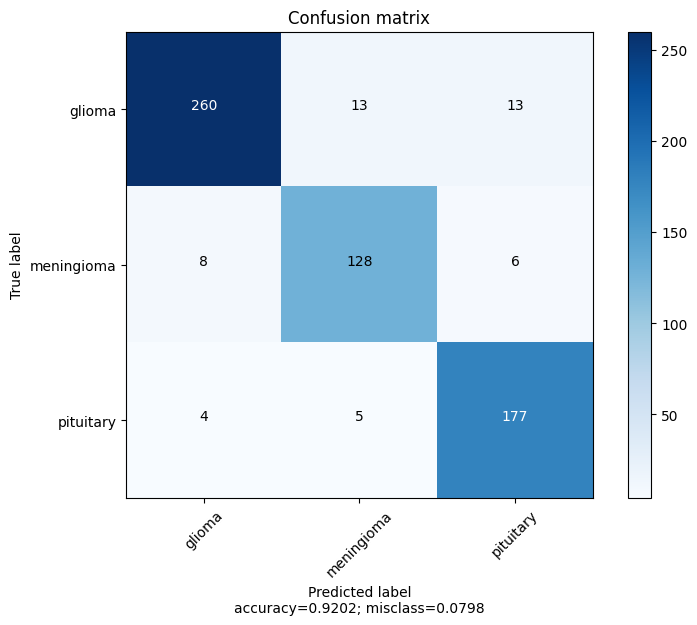

In [6]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
                             
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='without.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## Continuous three convolution layers

In [3]:
def block(inputs, filters):

    x = Conv2D(filters, 1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y


def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

2024-03-18 16:46:09.054338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 16:46:09.363265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Epoch 1/50


2024-03-18 16:46:17.949255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-18 16:46:18.804943: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-18 16:46:18.804959: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-18 16:46:18.805001: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-18 16:46:19.352025: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7173
Epoch 1: val_accuracy improved from -inf to 0.38615, saving model to model-test.h5
Epoch 1: 15.76 seconds
264/264 [==============================] - 16s 40ms/step - loss: 0.6936 - accuracy: 0.7173 - val_loss: 3.1426 - val_accuracy: 0.3861 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3747 - accuracy: 0.8511
Epoch 2: val_accuracy did not improve from 0.38615
Epoch 2: 9.37 seconds
264/264 [==============================] - 9s 35ms/step - loss: 0.3746 - accuracy: 0.8512 - val_loss: 15.8158 - val_accuracy: 0.3444 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8960
Epoch 3: val_accuracy improved from 0.38615 to 0.75427, saving model to model-test.h5
Epoch 3: 9.52 seconds
264/264 [==============================] - 10s 36ms/step - loss: 0.2697 - accuracy: 0.8959 - val_loss: 0.6759 - val_accuracy: 0.7543 - l

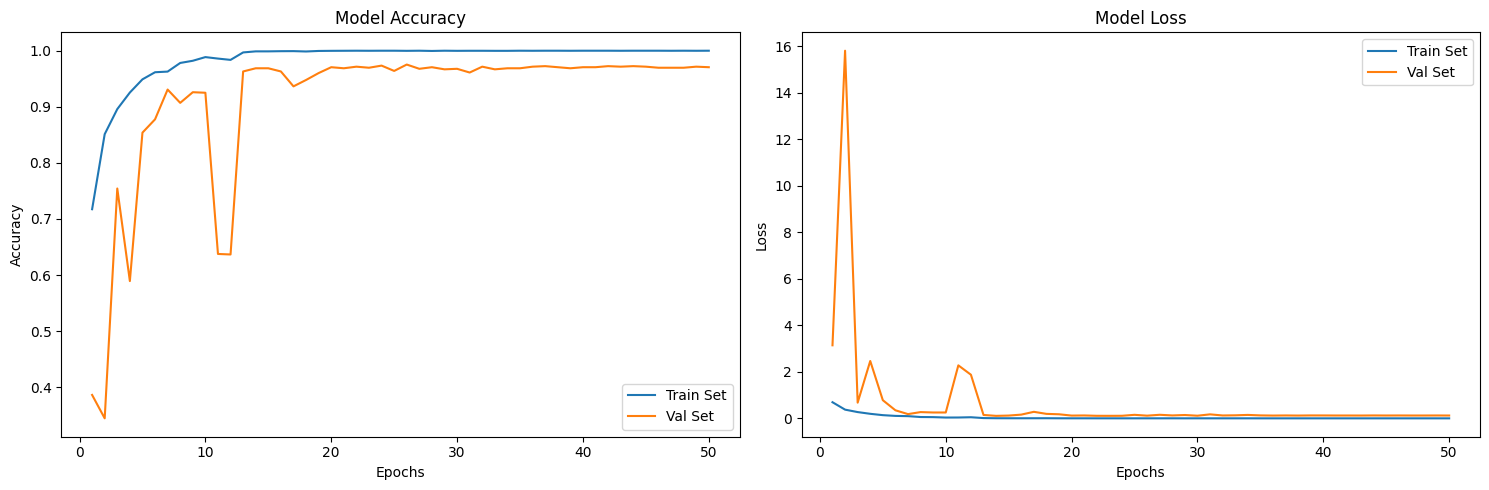

20/20 [==============================] - 0s 9ms/step - loss: 0.1098 - accuracy: 0.9609
Test Accuracy:  96.09
              precision    recall  f1-score   support

      glioma     0.9721    0.9755    0.9738       286
  meningioma     0.9357    0.9225    0.9291       142
   pituitary     0.9626    0.9677    0.9651       186

    accuracy                         0.9609       614
   macro avg     0.9568    0.9553    0.9560       614
weighted avg     0.9608    0.9609    0.9608       614



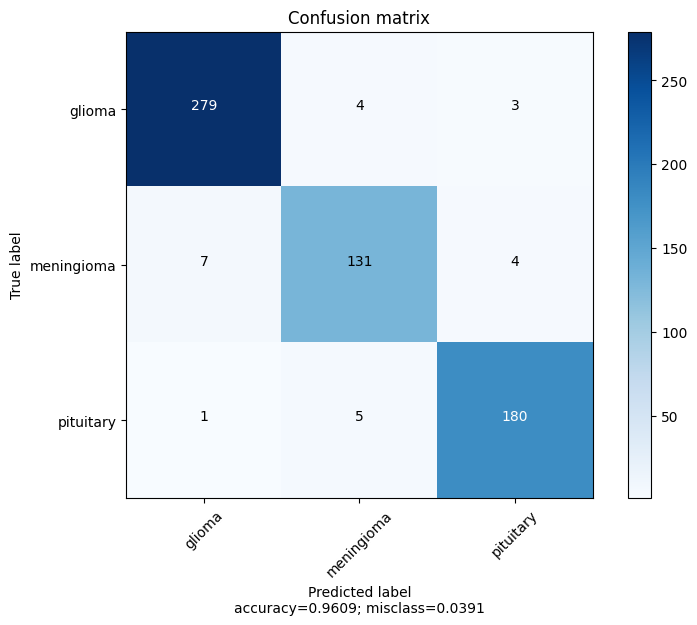

In [4]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
                             
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='continuous.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## RMF

In [10]:
def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x

def block(inputs, filters):
    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Conv2D(filters, 3, padding='same')(a)
    b = BatchNormalization()(b)
    b = ReLU()(b)
    
    c = Conv2D(filters, 3, padding='same')(b)
    c = BatchNormalization()(c)
    c = ReLU()(c)
    
    d = Conv2D(filters, 3, padding='same')(c)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    mid = Concatenate()([a, b, c, d])
    mid = Conv2D(2 * filters, 1, padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = ReLU()(mid)
    
    x = Conv2D(filters * 2, 1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Add()([mid, x])
    
    y = Conv2D(filters * 2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7227
Epoch 1: val_accuracy improved from -inf to 0.43169, saving model to model-test.h5
Epoch 1: 15.42 seconds
264/264 [==============================] - 15s 48ms/step - loss: 0.6753 - accuracy: 0.7227 - val_loss: 3.3785 - val_accuracy: 0.4317 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8596
Epoch 2: val_accuracy improved from 0.43169 to 0.53890, saving model to model-test.h5
Epoch 2: 11.54 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.3612 - accuracy: 0.8598 - val_loss: 3.2817 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9112
Epoch 3: val_accuracy improved from 0.53890 to 0.56641, saving model to model-test.h5
Epoch 3: 11.53 seconds
264/264 [==============================] - 12s 44ms/step - loss: 0.2366 - accuracy: 0.91

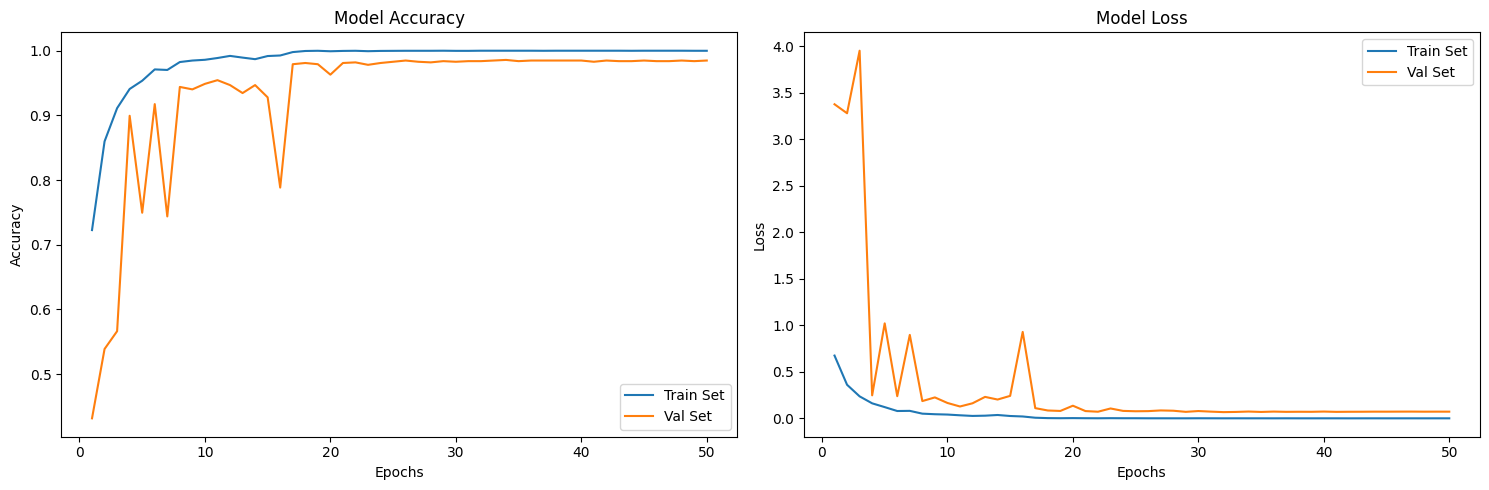

20/20 [==============================] - 0s 11ms/step - loss: 0.0947 - accuracy: 0.9625
Test Accuracy:  96.25
              precision    recall  f1-score   support

      glioma     0.9686    0.9720    0.9703       286
  meningioma     0.9301    0.9366    0.9333       142
   pituitary     0.9783    0.9677    0.9730       186

    accuracy                         0.9625       614
   macro avg     0.9590    0.9588    0.9589       614
weighted avg     0.9626    0.9625    0.9626       614



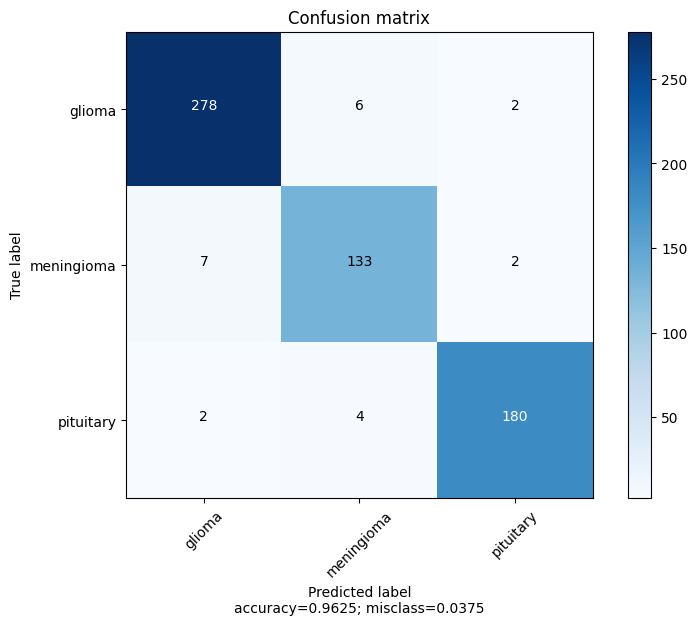

In [11]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='RMF.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## MFL

In [12]:
def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x

def block(inputs, filters):
    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Conv2D(filters, 3, padding='same')(a)
    b = BatchNormalization()(b)
    b = ReLU()(b)
    
    c = Conv2D(filters, 3, padding='same')(b)
    c = BatchNormalization()(c)
    c = ReLU()(c)
    
    d = Conv2D(filters, 3, padding='same')(c)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    mid = Concatenate()([a, b, c, d])
    mid = Conv2D(2 * filters, 1, padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = ReLU()(mid)
    
    x = Conv2D(filters * 2, 1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Add()([mid, x])
    
    y = Conv2D(filters * 2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def mini_block(filters, x):
    conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding = "same")(x)
    bn = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.ReLU()(bn)
    return act

def double_mini_block(filters, x):
    t = mini_block(filters, x)
    t = mini_block(filters, t)
    return t

def MFL_Block(f,inp):
    block1 = mini_block(f,inp)
    block2 = double_mini_block(f,inp)
    c1 =  Concatenate()([block1, block2])
    conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c1)
    block3 = mini_block(f,conv)
    block4 = mini_block(f,inp)
    c2 = Concatenate()([block3, block4])
    conv = tf.keras.layers.Conv2D(f, kernel_size=(1, 1))(c2)
    return conv


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = MFL_Block(128, x)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = MFL_Block(256, x)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = MFL_Block(512, x)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.8088 - accuracy: 0.6835
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to model-test.h5
Epoch 1: 17.98 seconds
264/264 [==============================] - 18s 62ms/step - loss: 0.8089 - accuracy: 0.6834 - val_loss: 17.9365 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.8016
Epoch 2: val_accuracy improved from 0.33207 to 0.46395, saving model to model-test.h5
Epoch 2: 15.65 seconds
264/264 [==============================] - 16s 59ms/step - loss: 0.5169 - accuracy: 0.8018 - val_loss: 5.2723 - val_accuracy: 0.4639 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.4978 - accuracy: 0.8052
Epoch 3: val_accuracy did not improve from 0.46395
Epoch 3: 15.42 seconds
264/264 [==============================] - 15s 58ms/step - loss: 0.4981 - accuracy: 0.8052 - val_loss: 4.2838 - val_accura

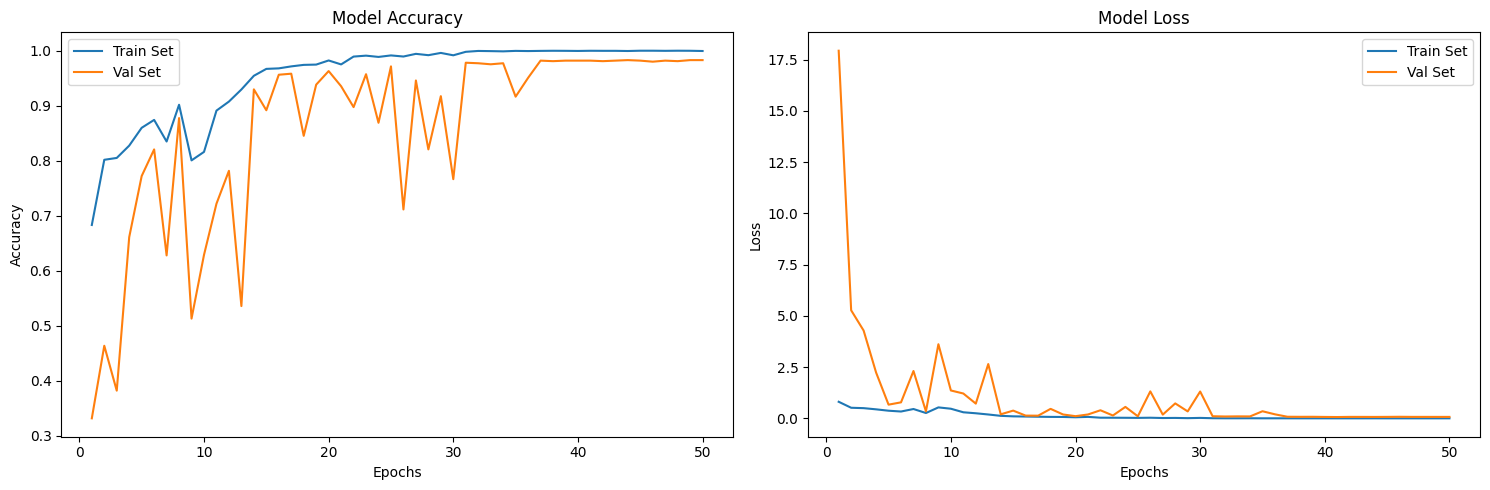

20/20 [==============================] - 0s 16ms/step - loss: 0.1694 - accuracy: 0.9544
Test Accuracy:  95.44
              precision    recall  f1-score   support

      glioma     0.9650    0.9650    0.9650       286
  meningioma     0.9091    0.9155    0.9123       142
   pituitary     0.9730    0.9677    0.9704       186

    accuracy                         0.9544       614
   macro avg     0.9490    0.9494    0.9492       614
weighted avg     0.9545    0.9544    0.9544       614



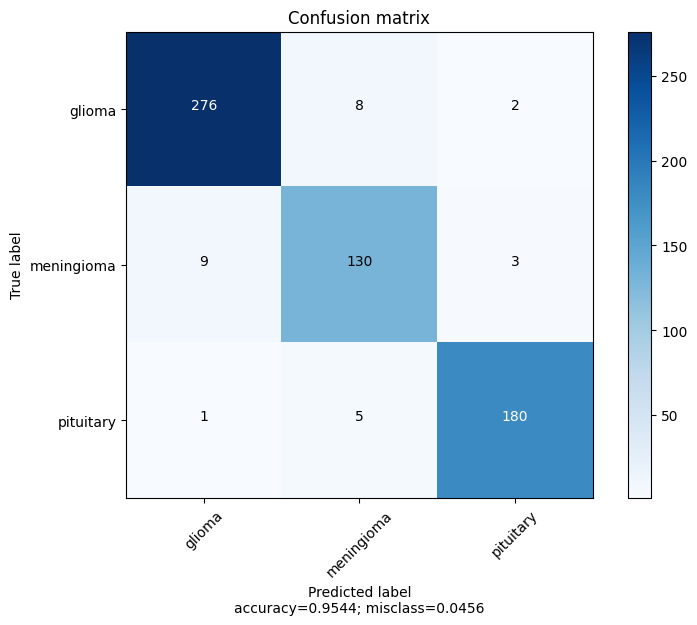

In [15]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='MFL.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)